**INSTALLS**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/ML4641_Team1/

/content/drive/MyDrive/ML4641_Team1


In [ ]:
!pip install -q -U tensorflow_decision_forests
!pip install -q -U dtreeviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 35.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 36.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 808.6 kB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import tensorflow_decision_forests as tfdf
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from dtreeviz.utils import extract_params_from_pipeline
from sklearn import tree
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.tree import export_graphviz
import graphviz
import dtreeviz
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

# avoid "Arial font not found" warnings
import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)

**HELPER FUNCTIONS**

Function 1: Cleans Data based off of Z-score [working]

In [ ]:
# This functions removes all rows from the DataFrame df whose feature value has z-score above 3 or below -3
def remove_outliers_Z_score(df: pd.DataFrame, feature: str):
    z_scores = np.abs(stats.zscore(df[feature]))
    too_high_indices =  np.where(z_scores > 3)[0]
    too_low_indices = np.where(z_scores < -3)[0]
    df.drop(index = too_high_indices, inplace = True)
    df.drop(index = too_low_indices, inplace = True)

Function 2: Cleans Data based off of IQR [not working]

In [ ]:
# This function removes all rows from the DataFrame df whose feature value is above Q3 + 1.5 * IQR or below Q1 - 1.5 * IQR
# UPDATE: This is giving me issues. Probably better to use Z-score to remove outliers for this dataset
def remove_outliers_IQR(df: pd.DataFrame, feature: str):
    Q1 = np.percentile(df[feature], 25, method = 'midpoint')
    Q3 = np.percentile(df[feature], 75, method = 'midpoint')
    IQR = Q3 - Q1
    too_high_indices = np.where(df[feature] >= Q3 + 1.5 * IQR)[0]
    too_low_indices = np.where(df[feature] <= Q1 - 1.5 * IQR)[0]
    df.drop(index = too_high_indices, inplace = True)
    df.drop(index = too_low_indices, inplace = True)

Function 3: Splits pandas DataFrame into training set and testing set

In [ ]:
# This function splits a pandas DataFrame into a training set and a test set, specificed by the train_ratio.
def split_dataset(df: pd.DataFrame, train_ratio: float):
  train_indices = np.random.rand(len(df)) < train_ratio
  return df[train_indices], df[~train_indices]

**LOAD DATA**

In [ ]:
property_and_user_activity_df = pd.read_csv("/content/drive/MyDrive/ML4641_Team1/Datasets/kaggle-rental-properties/property_and_user_activity.csv")

<ipython-input-8-1f0023293ca2>:1: DtypeWarning: Columns (6,9) have mixed types. Specify dtype option on import or set low_memory=False.


**VISUALIZE DATA**

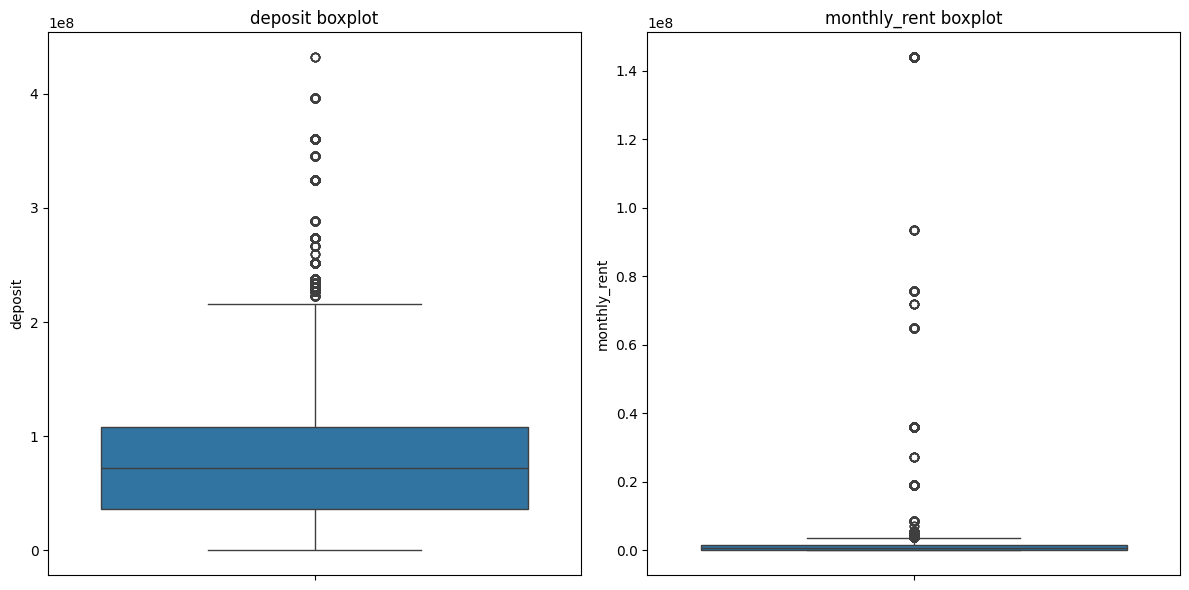

In [ ]:
# Visualize the data- this will be helpful in removing outliers later

plt.figure(figsize=(12, 6))

# First Boxplot
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
sns.boxplot(property_and_user_activity_df['deposit'])
plt.title('deposit boxplot')

# Second Boxplot
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
sns.boxplot(property_and_user_activity_df['monthly_rent'])
plt.title('monthly_rent boxplot')

plt.tight_layout()  # Adjust layout to not overlap
plt.show()


**CLEAN AND RUN**

In [ ]:
print("-----STARTING-----\n")

######################################
########### Clean the data ###########
######################################

# Convert text to numbers via one-hot encoding. Then we can handle missing data
encoder = OneHotEncoder()

# Encode event_type to 1 if it gives reasonable indication that the user would like to rent the house.
property_and_user_activity_df['event_type_num'] = property_and_user_activity_df['event_type'].map(lambda x: 1 if x in ['deal-success', 'meeting-success', 'visit-success', 'visit-new'] else 0)

# Encode categorical variables

property_and_user_activity_df['has_elevator'] = property_and_user_activity_df['has_elevator'].astype('category')
property_and_user_activity_df['elevator'] = property_and_user_activity_df['has_elevator'].cat.codes

property_and_user_activity_df['has_storage_area'] = property_and_user_activity_df['has_storage_area'].astype('category')
property_and_user_activity_df['storage'] = property_and_user_activity_df['has_storage_area'].cat.codes


property_and_user_activity_encoded = pd.DataFrame(encoder.fit_transform(
    property_and_user_activity_df[['event_type_num']]).toarray())

property_and_user_activity_encoded = property_and_user_activity_df.join(property_and_user_activity_encoded)

# Fill all missing values with the mode of their respective column
property_and_user_activity_encoded = property_and_user_activity_df.fillna(property_and_user_activity_df.mode().iloc[0])

##### DO WE STILL WANT TO DROP ROWS WHERE RENT IS ZERO? #####

property_and_user_activity_encoded.to_csv("/content/drive/MyDrive/ML4641_Team1/Datasets/kaggle-rental-properties/property_and_user_activity_encoded.csv")

############################################################################
########### Now the data is cleaned, and we can train our model. ###########
############################################################################

# Split the data (80% for training, 20% for testing)
features = ["room_qty", "unit_area", "elevator", "building_floor_count", "storage"]
target = "event_type_num"
train_set, test_set = split_dataset(property_and_user_activity_encoded, 0.8)

# Only keep the features we want to study.
train_set_with_kept_features = train_set[features + [target]]
test_set_with_kept_features = test_set[features + [target]]

# Convert to TensorFlow datasets
train_tf_set = tfdf.keras.pd_dataframe_to_tf_dataset(train_set_with_kept_features, label=target)
test_tf_set = tfdf.keras.pd_dataframe_to_tf_dataset(test_set_with_kept_features, label=target)

# Train the model
dt_model = tfdf.keras.RandomForestModel(verbose=0, random_seed=1234)
dt_model.fit(train_tf_set)

# Evaluate accuracy
dt_model.compile(metrics=["accuracy"])
print(dt_model.evaluate(test_tf_set, return_dict=True, verbose=0))

print("\n-----FINISHED-----")


-----STARTING-----

{'loss': 0.0, 'accuracy': 0.9935582280158997}

-----FINISHED-----


**DISPLAY RESULTS**

In [ ]:
print("-----STARTING-----")

# Display results
dt_viz = dtreeviz.model(dt_model, tree_index=0,
                           X_train=train_set[features], y_train=train_set[target],
                           feature_names=features,
                           target_name=target)

v = dt_viz.view()
v.show()
v.save("/content/drive/MyDrive/ML4641_Team1/dt_viz.svg")

print("\n-----FINISHED-----")

-----STARTING-----

-----FINISHED-----


**EVALUATE ACCURACY IN DETAIL**

In [ ]:
print("-----STARTING-----")
# from Arian's version of this notebook
# Evaluate accuracy
dt_model.compile(metrics=['accuracy'])
results = dt_model.evaluate(test_tf_set, return_dict=True, verbose=0)
predictions = dt_model.predict(test_tf_set)
ground_truths = test_set_with_kept_features[target].values

# Get predicted values of y, and evaluate them.
y_pred = np.argmax(predictions, axis = 1)
precision = precision_score(ground_truths, y_pred, average='weighted')
recall = recall_score(ground_truths, y_pred, average='weighted')
f1 = f1_score(ground_truths, y_pred, average='weighted')

print("Accuracy:", results['accuracy'])
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

print("\n-----FINISHED-----")

-----STARTING-----
65/65 [==============================] - 3s 36ms/step
Accuracy: 0.9935582280158997
Precision: 0.9807222323818915
Recall: 0.990314208916489
F1 Score: 0.9854948811482269

-----FINISHED-----


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
